<a href="https://colab.research.google.com/github/Nastarii/PCB-defect-detection/blob/main/Faster_Rcnn_PCB_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -qq /content/drive/MyDrive/pcb_huang_wei.zip

In [ ]:
import torch

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [ ]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET

class Annotation():
    def __init__(self,paths):
        self.dfs = []
        for path in paths:
            self.path = path
            self.df = self.xml_to_df()
            self.dfs.append(self.df)
            self.df_to_csv()
        self.merge_csv()
        self.save_df()        

    def xml_to_df(self):
        xml_list = []
        for xml_file in glob.glob(self.path + '/*.xml'):
            tree = ET.parse(xml_file)
            root = tree.getroot()
            for member in root.findall('object'):
                value = (root.find('filename').text,
                        int(root.find('size')[0].text),
                        int(root.find('size')[1].text),
                        member[0].text,
                        int(member[4][0].text),
                        int(member[4][1].text),
                        int(member[4][2].text),
                        int(member[4][3].text)
                        )
                xml_list.append(value)
        column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
        xml_df = pd.DataFrame(xml_list, columns=column_name)
        return xml_df

    def df_to_csv(self):
        self.df.to_csv(self.path + '/' + self.df['class'].unique()[0] + '.csv')

    def merge_csv(self):
        self.dataframe = pd.concat(self.dfs,axis=0, ignore_index=True)

    def save_df(self):
        self.dataframe.to_csv('/content/df.csv')


In [ ]:
xml_paths = glob.glob('/content/PCB_DATASET/Annotations/*')
df = Annotation(xml_paths).dataframe

In [ ]:
import numpy as np

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
CLASSES = np.append(df['class'].unique(),'background')
NUM_CLASSES = len(CLASSES)
BATCH_SIZE = 4
NUM_EPOCHS = 50
RESIZE_LEN = 512
OUT_DIR = '/content'

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
!pip -qq install albumentations==0.4.6

     |████████████████████████████████| 117 kB 5.3 MB/s 
     |████████████████████████████████| 948 kB 35.8 MB/s 


In [ ]:
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import albumentations as A
import cv2 as cv

def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        A.RandomRotate90(0.5),
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc', 
        'label_fields': ['labels']
    })

In [ ]:
def show_tranformed_image(train_loader):
    if len(train_loader) > 0:
        for i in range(1):
            images, targets = next(iter(train_loader))
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
            sample = images[i].permute(1, 2, 0).cpu().numpy()
            for box in boxes:
                cv.rectangle(sample,
                            (box[0], box[1]),
                            (box[2], box[3]),
                            (0, 0, 255), 2)
            plt.imshow(sample)

In [ ]:
from torch.utils.data import Dataset, DataLoader

class PCBDataset(Dataset):
    def __init__(self, dir_path,df, size,classes, transforms=None):
        self.new_w, self.new_h  = (size,size)
        self.filenames = os.listdir(dir_path)
        self.transforms = transforms
        self.dir_path = dir_path
        self.classes = list(classes)
        self.df = df

    def __getitem__(self, idx):
  
        filename = self.filenames[idx]

        image_path = os.path.join(self.dir_path,filename)
        image = cv.imread(image_path)[:,:,::-1]
       
        image = cv.resize(image, (self.new_w, self.new_h))
        image = image.astype(np.float32)
        image /= 255.0
        
        annot = self.df.loc[self.df['filename'] == filename]

        boxes, labels = [], []
        
        for filename, w, h, classes, xmin, ymin,xmax,ymax in annot.values:
           
            labels.append(self.classes.index(classes))
            
            xmin_final = (xmin/w)*self.new_w
            xmax_final = (xmax/w)*self.new_w
            ymin_final = (ymin/h)*self.new_h
            yamx_final = (ymax/h)*self.new_h
            
            boxes.append([xmin_final, ymin_final, xmax_final, yamx_final])
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
  
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
 
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id

        if self.transforms:
            sample = self.transforms(image = image,
                                     bboxes = target['boxes'],
                                     labels = labels)
            image = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
        return image, target

    def __len__(self):
        return len(self.filenames)

In [ ]:
images_dir = glob.glob('/content/PCB_DATASET/images/*')

In [ ]:
!mkdir /content/dataset
!mkdir /content/dataset/train
!mkdir /content/dataset/val

In [ ]:
import shutil

for path in images_dir:
    img_paths = glob.glob(path + '/*.jpg')
    train_paths = img_paths[:85]
    val_paths = img_paths[85:]
    for img in train_paths:
        shutil.copyfile(img, '/content/dataset/train/' + str(os.path.basename(img)))
    for img in val_paths:
        shutil.copyfile(img, '/content/dataset/val/' + str(os.path.basename(img)))

In [ ]:
train_files = os.listdir('/content/dataset/train/')
val_files = os.listdir('/content/dataset/val/')

In [ ]:
TRAIN_DF = df.loc[df['filename'].isin(train_files)].reset_index(drop=True)
VAL_DF = df.loc[df['filename'].isin(val_files)].reset_index(drop=True)

In [ ]:
SPLIT_SIZE = len(VAL_DF)/len(TRAIN_DF)
print(f'{round(SPLIT_SIZE*100,2)}%')

36.9%


In [ ]:
TRAIN_DIR = '/content/dataset/train'
VAL_DIR   = '/content/dataset/val'

In [ ]:
train_dataset = PCBDataset(TRAIN_DIR, TRAIN_DF, RESIZE_LEN, CLASSES, get_train_transform())
valid_dataset = PCBDataset(VAL_DIR, VAL_DF, RESIZE_LEN, CLASSES, get_valid_transform())

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}\n")

Number of training samples: 510
Number of validation samples: 183



In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)


in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)
model = model.to(DEVICE)

params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [ ]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
    def send(self, value):
        self.current_total += value
        self.iterations += 1
    
    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations
    
    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [ ]:
from tqdm.auto import tqdm
import torch
import time

plt.style.use('ggplot')

In [ ]:
def train(train_data_loader, model):
    print('Training')
    global train_itr
    global train_loss_list
    
     # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value)
        train_loss_hist.send(loss_value)
        losses.backward()
        optimizer.step()
        train_itr += 1
    
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return train_loss_list

In [ ]:
def validate(valid_data_loader, model):
    print('Validating')
    global val_itr
    global val_loss_list
    
    # initialize tqdm progress bar
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    
    for i, data in enumerate(prog_bar):
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            loss_dict = model(images, targets,)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)
        val_loss_hist.send(loss_value)
        val_itr += 1
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list


EPOCH 1 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Validating


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch #0 train loss: 0.593
Epoch #0 validation loss: 0.459
Took 5.443 minutes for epoch 0

EPOCH 2 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validating


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch #1 train loss: 0.463
Epoch #1 validation loss: 0.466
Took 5.332 minutes for epoch 1
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 3 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validating


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch #2 train loss: 0.476
Epoch #2 validation loss: 0.479
Took 5.329 minutes for epoch 2

EPOCH 4 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validating


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch #3 train loss: 0.457
Epoch #3 validation loss: 0.466
Took 5.327 minutes for epoch 3
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 5 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validating


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch #4 train loss: 0.448
Epoch #4 validation loss: 0.424
Took 5.332 minutes for epoch 4

EPOCH 6 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validating


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch #5 train loss: 0.423
Epoch #5 validation loss: 0.412
Took 5.343 minutes for epoch 5
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 7 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validating


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch #6 train loss: 0.398
Epoch #6 validation loss: 0.371
Took 5.347 minutes for epoch 6

EPOCH 8 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validating


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch #7 train loss: 0.372
Epoch #7 validation loss: 0.363
Took 5.333 minutes for epoch 7
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 9 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validating


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch #8 train loss: 0.364
Epoch #8 validation loss: 0.368
Took 5.335 minutes for epoch 8

EPOCH 10 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validating


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch #9 train loss: 0.349
Epoch #9 validation loss: 0.321
Took 5.336 minutes for epoch 9
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 11 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validating


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch #10 train loss: 0.333
Epoch #10 validation loss: 0.348
Took 5.335 minutes for epoch 10

EPOCH 12 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validating


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch #11 train loss: 0.333
Epoch #11 validation loss: 0.331
Took 5.343 minutes for epoch 11
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 13 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validating


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch #12 train loss: 0.322
Epoch #12 validation loss: 0.317
Took 5.347 minutes for epoch 12

EPOCH 14 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validating


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch #13 train loss: 0.320
Epoch #13 validation loss: 0.306
Took 5.351 minutes for epoch 13
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 15 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validating


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch #14 train loss: 0.316
Epoch #14 validation loss: 0.326
Took 5.346 minutes for epoch 14

EPOCH 16 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validating


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch #15 train loss: 0.306
Epoch #15 validation loss: 0.311
Took 5.346 minutes for epoch 15
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 17 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validating


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch #16 train loss: 0.309
Epoch #16 validation loss: 0.328
Took 5.337 minutes for epoch 16

EPOCH 18 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validating


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch #17 train loss: 0.301
Epoch #17 validation loss: 0.305
Took 5.343 minutes for epoch 17
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 19 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validating


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch #18 train loss: 0.292
Epoch #18 validation loss: 0.313
Took 5.347 minutes for epoch 18

EPOCH 20 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validating


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch #19 train loss: 0.286
Epoch #19 validation loss: 0.306
Took 5.359 minutes for epoch 19
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 21 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validating


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch #20 train loss: 0.288
Epoch #20 validation loss: 0.297
Took 5.319 minutes for epoch 20

EPOCH 22 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validating


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch #21 train loss: 0.279
Epoch #21 validation loss: 0.299
Took 5.325 minutes for epoch 21
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 23 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validating


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch #22 train loss: 0.281
Epoch #22 validation loss: 0.291
Took 5.324 minutes for epoch 22

EPOCH 24 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validating


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch #23 train loss: 0.276
Epoch #23 validation loss: 0.301
Took 5.317 minutes for epoch 23
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 25 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validating


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch #24 train loss: 0.276
Epoch #24 validation loss: 0.305
Took 5.314 minutes for epoch 24

EPOCH 26 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validating


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch #25 train loss: 0.274
Epoch #25 validation loss: 0.298
Took 5.320 minutes for epoch 25
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 27 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validating


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch #26 train loss: 0.271
Epoch #26 validation loss: 0.301
Took 5.315 minutes for epoch 26

EPOCH 28 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validating


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch #27 train loss: 0.269
Epoch #27 validation loss: 0.284
Took 5.313 minutes for epoch 27
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 29 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validating


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch #28 train loss: 0.269
Epoch #28 validation loss: 0.302
Took 5.319 minutes for epoch 28

EPOCH 30 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

Validating


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch #29 train loss: 0.264
Epoch #29 validation loss: 0.282
Took 5.322 minutes for epoch 29
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 31 of 50
Training


  0%|          | 0/128 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

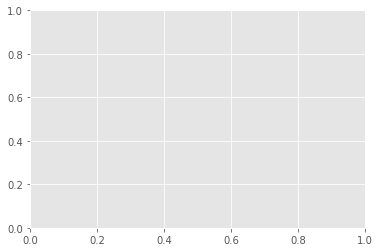

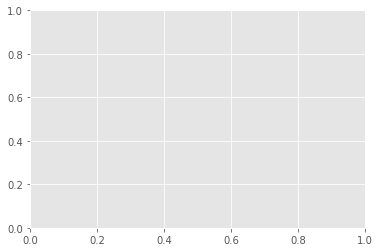

In [ ]:
train_loss_hist = Averager()
val_loss_hist = Averager()
train_itr = 1
val_itr = 1
# train and validation loss lists to store loss values of all...
# ... iterations till ena and plot graphs for all iterations
train_loss_list = []
val_loss_list = []
# name to save the trained model with
MODEL_NAME = 'model'

# start the training epochs
for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")
    # reset the training and validation loss histories for the current epoch
    train_loss_hist.reset()
    val_loss_hist.reset()
    # create two subplots, one for each, training and validation
    figure_1, train_ax = plt.subplots()
    figure_2, valid_ax = plt.subplots()
    # start timer and carry out training and validation
    start = time.time()
    train_loss = train(train_loader, model)
    val_loss = validate(valid_loader, model)
    print(f"Epoch #{epoch} train loss: {train_loss_hist.value:.3f}")   
    print(f"Epoch #{epoch} validation loss: {val_loss_hist.value:.3f}")   
    end = time.time()
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")
    if (epoch+1) % 2 == 0: # save model after every n epochs
        torch.save(model.state_dict(), f"{OUT_DIR}/model{epoch+1}.pth")
        print('SAVING MODEL COMPLETE...\n')
    
    if (epoch+1) % 2 == 0: # save loss plots after n epochs
        train_ax.plot(train_loss, color='blue')
        train_ax.set_xlabel('iterations')
        train_ax.set_ylabel('train loss')
        valid_ax.plot(val_loss, color='red')
        valid_ax.set_xlabel('iterations')
        valid_ax.set_ylabel('validation loss')
        figure_1.savefig(f"{OUT_DIR}/train_loss_{epoch+1}.png")
        figure_2.savefig(f"{OUT_DIR}/valid_loss_{epoch+1}.png")
        print('SAVING PLOTS COMPLETE...')
    
    if (epoch+1) == NUM_EPOCHS: # save loss plots and model once at the end
        train_ax.plot(train_loss, color='blue')
        train_ax.set_xlabel('iterations')
        train_ax.set_ylabel('train loss')
        valid_ax.plot(val_loss, color='red')
        valid_ax.set_xlabel('iterations')
        valid_ax.set_ylabel('validation loss')
        figure_1.savefig(f"{OUT_DIR}/train_loss_{epoch+1}.png")
        figure_2.savefig(f"{OUT_DIR}/valid_loss_{epoch+1}.png")
        torch.save(model.state_dict(), f"{OUT_DIR}/model{epoch+1}.pth")
    
    plt.close('all')